In [7]:
import sys
sys.path.append('..')
# reload local packages automatically
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)

# Import packages.
import cvxpy as cp
import numpy as np

import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2.638300722408311e-07
2.0772161170510943e-07


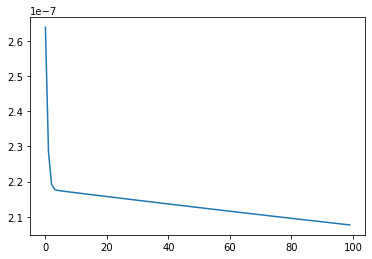

In [163]:
from opentn.transformations import create_kitaev_liouvillians, exp_operator_dt, factorize_psd, super2choi
d, N = 2, 4
dim = d**N
Lvec, Lvec_odd, Lvec_even, Lnn = create_kitaev_liouvillians(N=N, d=d, gamma=1e-2)
tau = 4
superops_exp = []
for i, op in enumerate([Lvec, Lvec_odd, Lvec_even]):
    if i == 1:
        superops_exp.append(exp_operator_dt(op, tau/2, 'jax'))
    else:
        superops_exp.append(exp_operator_dt(op, tau, 'jax'))
exp_Lvec, exp_Lvec_odd, exp_Lvec_even = superops_exp

X1, eigvals1 = factorize_psd(psd=super2choi(exp_Lvec_odd), tol=1e-12)
X2, eigvals2 = factorize_psd(psd=super2choi(exp_Lvec_even), tol=1e-12)

from opentn.optimization import gds, frobenius_norm, model_Ys, compute_loss
cost_n4, grads_n4, xi_n4 = gds(fn=compute_loss, x0=[X1, X2, X1], iter=100, loss_fn=frobenius_norm, model=model_Ys, rate=1.5e-9, exact = exp_Lvec, show_cost=False)
print(cost_n4[0])
print(cost_n4[-1])

plt.plot(cost_n4)

In [71]:
from opentn.transformations import super2choi, choi_composition, partial_transpose
from opentn.optimization import small2zero
from scipy import sparse

# rest of matrices optimized with GSD
X2 = xi_n4[-1][1]
X3 = xi_n4[-1][2]
Y2 = X2@X2.conj().T
Y3 = X3@X3.conj().T

# rhs to which we want to approximate
rhs = np.asarray(super2choi(superop=exp_Lvec, dim=dim))
srhs = sparse.csr_matrix(rhs) # small2zero was deleted
srhs = srhs.astype(np.float64)

# change partial transpose to A
A = choi_composition(C1=Y2, C2=Y3, dim=dim) # small2zero was deleted
A_tb = partial_transpose(A, dims=[dim, dim], idx=1)
I = np.eye(dim)
A_tbxI = np.kron(A_tb, I)
sA_tbxI = sparse.csr_matrix(A_tbxI)
sA_tbxI = sA_tbxI.astype(np.float64)
sA_tbxI

/Users/emiliano_gr/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/scipy/sparse/_data.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  self._deduped_data().astype(dtype, casting=casting, copy=copy),


<4096x4096 sparse matrix of type '<class 'numpy.float64'>'
	with 304704 stored elements in Compressed Sparse Row format>

In [72]:
X = cp.Variable((dim**2,dim**2), PSD=True)
lhs =  cp.partial_trace(sA_tbxI @ cp.kron(I, X), dims=[dim, dim, dim], axis=1)
cost = cp.norm(lhs - srhs, "fro")
prob = cp.Problem(cp.Minimize(cost))

print(cp.installed_solvers())

['ECOS', 'ECOS_BB', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


In [73]:
prob.solve(solver=cp.SCS, verbose=True, canon_backend=cp.SCIPY_CANON_BACKEND)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jul 19 12:19:24 AM: Your problem has 65536 variables, 0 constraints, and 0 parameters.
(CVXPY) Jul 19 12:19:24 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 19 12:19:24 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 19 12:19:24 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 19 12:19:24 AM: Compiling problem (target solver=SCS).
(CVXPY) Jul 19 12:19:24 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

(CVXPY) Jul 19 12:19:24 AM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 19 12:19:24 AM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 19 01:24:20 AM: Applying reduction SCS
(CVXPY) Jul 19 01:24:20 AM: Finished problem compilation (took 3.896e+03 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jul 19 01:24:20 AM: Invoking solver SCS  to obtain a solution.
------------------------------------------------------------------
	       SCS v3.2.3 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 32897, constraints m: 98433
cones: 	  q: soc vars: 65537, qsize: 1
	  s: psd vars: 32896, ssize: 1
settings: eps_abs: 1.0e-05, eps_rel: 1.0e-05, eps_infeas: 1.0e-07
	  alpha: 

2.616657054528783e-07

In [90]:
# we need to check that the cost function created through cvxpy is the same as with compute_loss, model_Ys, frobenius_norm**2
def cost_cvxpy(C1, C2, rhs, dim):
    I = np.eye(dim)
    C2_tb = partial_transpose(C2, dims=[dim, dim], idx=1)
    C2_tbxI = np.kron(C2_tb, I)
    C2_tbxI = sparse.csr_matrix(C2_tbxI)
    C2_tbxI = C2_tbxI.astype(np.float64)

    srhs = sparse.csr_matrix(rhs) # small2zero was deleted
    srhs = srhs.astype(np.float64)

    lhs =  cp.partial_trace(C2_tbxI @ cp.kron(I, C1), dims=[dim, dim, dim], axis=1)
    cost = cp.norm(lhs - srhs, "fro")
    return cost.value 

# cost_cvxpy(X.value, A, rhs, dim) # it gives the same result but we just have to add the small2zero thing
# would it help not adding the small2zero thing? 

In [228]:
from opentn.transformations import choi2super
X1opt = xi_n4[-1][0]
print(frobenius_norm(choi_composition(X1opt@X1opt.conj().T, A), rhs))
print(cost_cvxpy(X1opt@X1opt.conj().T, A, rhs, dim))
# check if the cost function would be the same if we used superoperators instead of choi matrices.
# this includes not using sparse matrices
print(frobenius_norm(choi2super(A)@choi2super(X1opt@X1opt.conj().T), exp_Lvec))

2.0762417533163998e-07


/Users/emiliano_gr/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/scipy/sparse/_data.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  self._deduped_data().astype(dtype, casting=casting, copy=copy),


2.0762417532526505e-07
2.0762417533163993e-07


In [229]:
# now we do the same calculations but with the optimal value obtained from cvxpy
print(frobenius_norm(choi_composition(X.value, A), rhs)) # value when small2zero was used on A and rhs: 2.6522855638959974e-07
print(cost_cvxpy(X.value, A, rhs, dim))
# similar to above, we use only the superoperators
print(frobenius_norm(choi2super(A)@choi2super(X.value), exp_Lvec))

2.616657054312103e-07
2.616657054528783e-07
2.616657054312103e-07


In [230]:
print(rhs.dtype)
print(X.value.dtype)

complex128
float64


In [80]:
np.linalg.norm(X.value - X1opt@X1opt.conj().T)

3.118308142720801e-07

In [218]:
cost.is_convex()

True

In [215]:
np.linalg.matrix_rank(X.value, tol=1e-9)

22

In [110]:
np.linalg.matrix_rank(X1opt)

4

In [216]:
X1opt.shape == X.value.shape == (256, 256)

True

In [236]:
# checking if the matrices we obtained are actually purely real:
# (OLD): if any(x == True for x in np.iscomplex(rhs).flatten())
for op in [X2, X3, Y2, Y3, X1opt, rhs, A]:
    print(np.linalg.norm(op.imag.flatten()))

0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [241]:
print(np.sort(np.linalg.svd(X1opt@X1opt.conj().T, compute_uv=False))[::-1][:32])
print('----')
print(np.sort(np.linalg.svd(X.value, compute_uv=False))[::-1][:32])
print('----')
print(np.sort(np.linalg.svd(X1@X1.conj().T, compute_uv=False))[::-1][:32])

[1.59601247e+01 1.99252051e-02 1.99252046e-02 2.48753645e-05
 8.48129654e-15 6.31816818e-15 6.20981924e-15 5.86025566e-15
 5.69412183e-15 5.48170099e-15 5.41871558e-15 5.25619571e-15
 4.87664228e-15 4.26100543e-15 4.06169438e-15 3.98294267e-15
 3.91318793e-15 3.61435904e-15 3.55661964e-15 3.02864385e-15
 2.85368560e-15 2.68083679e-15 2.39970236e-15 2.24273350e-15
 2.13402897e-15 2.07232794e-15 1.97635388e-15 1.86847837e-15
 1.66742613e-15 1.51372797e-15 1.49138543e-15 1.34797028e-15]
----
[1.59601247e+01 1.99251640e-02 1.99251539e-02 2.48791935e-05
 5.61805632e-08 4.34143461e-08 3.49806807e-08 3.37863474e-08
 2.87794764e-08 2.82106604e-08 2.72576795e-08 2.54720093e-08
 2.42538020e-08 2.35569031e-08 1.52808152e-08 1.15050625e-08
 8.56472063e-09 8.42259333e-09 7.62364212e-09 5.63844199e-09
 4.52040686e-09 1.51260275e-09 9.79361612e-10 5.45623628e-10
 4.99361261e-10 2.24398309e-10 1.64380794e-10 1.55086605e-10
 1.52183969e-10 1.33060393e-10 1.24028278e-10 1.23896898e-10]
----
[1.59601247e

# 24th July:
IDEA: is the configuration of the solver not good enough??
NOTE from workcomputer: random matrices (real and sparse) where taking 
- SCS: 235 min
- MOSEK: 289 min